In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn import linear_model
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter as sgf
from scipy.signal import find_peaks
import matplotlib as mpl
import seaborn as sns

'''
A bunch of small helper functions

'''
def scale(array):
    m = max(array)
    return array/m

def zero(array,num1=350):
    return array - np.average(array[num1:])

def binning(array,num):
    binarray=[]
    for i in range(int(len(array)/num)):
        binarray.append(np.average(array[num*i:num*(i+1)]))
    return np.array(binarray)

def flatten(list1):
    return [item for sublist in list1 for item in sublist]

def diffs(array):
    array = np.array(array)
    diff_arr = [array[1] - array[0]] + [(array[i+1]-array[i-1])/2 for i in range(1,len(array)-1)] + [array[-1] - array[-2]]
    return np.array(diff_arr)

def smooth(array,avnum):
    new_arr = [sum(array[i-avnum:i+avnum+1])/(2*avnum+1) for i in range(avnum,len(array)-avnum-1)]
    new_arr.extend(list(array[-1-avnum:]))
    s_arr = list(array[:avnum])
    s_arr.extend(new_arr)
    #print([len(array),len(s_arr)])
    return np.array(s_arr)

def binner(array,avnum):
    new_arr = [sum(array[i:i+avnum])/avnum for i in (range(0,len(array),avnum))]
    return np.array(new_arr)

'''
Main functions and objects used for analysis
'''

def get_plate(filename,search,nA=8,nX=12,splt='\t',discard = 'None'):
    # returns data from the matrix output of the platereader file in a nA x nB x nwavelength np.array
    # filename = the name and directory of the Dynatek Synergy platereader file
    # search = the string which is present at the end of each row. Usually, :Spectrum for absorption and
    # :EMSpectrum for emission
    # nA = the number of rows (A-H) used, usually 8
    # nB = the number of columns (1-12) used, usually 12
    # splt = element used to split the rows of the platereader file, usually a tab ('\t')
    plate = open(filename,'r').read().split('\n')
    plate_data = [[[] for i in range(nX)] for j in range(nA)]
    idict = {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'H' : 7}
    info = '()'
    if 'Spectrum' in search:
        info  = '(A)'
    elif 'EM Spectrum' in search:
        info = '(F)'
        
    index = []
    for i in plate:
        if 'Read' in i.split(splt):
            
            a = i.split(splt)[1].split(' ')
            if info in a:
                
                b = ([float(x.strip('[').strip('nm')) for x in a if 'nm' in x])
                c = ([float(a[i+1].strip(']')) for i in range(len(a)) if a[i] =='by'])
                wavenums = np.arange(b[0],b[1]+1,c[0])
        if search in i and splt in i:
            #print(i.split(splt))
            if discard!='None':
                if discard not in i:
                    li = i.split(splt)
                    ia = li[-1].index('#') - 1
                    b = idict[li[0]]
                    #print (li)
                    li1 = [k for k in li if not k== '']
                    for j in range(len(li1)-1):
                        if not li[0]+str(j) in index:
                            index.append(li[0]+str(j))
                        if li1[j] == 'OVRFLW':
                            plate_data[b][j-1].append(4)
                            #print(li1[j])
                        else:
                            try:
                                plate_data[b][j-1].append(float(li1[j]))
                                #print(li1[j])
                            except ValueError:
                                index.remove(li[0]+str(j))
            else:
                li = i.split(splt)
                ia = li[-1].index('#') - 1
                b = idict[li[0]]
                #print (li)
                li1 = [k for k in li if not k== '']
                for j in range(len(li1)-1):
                    if not li[0]+str(j) in index:
                        index.append(li[0]+str(j))
                    if li1[j] == 'OVRFLW':
                        plate_data[b][j-1].append(4)
                        #print(li1[j])
                    else:
                        try:
                            plate_data[b][j-1].append(float(li1[j]))
                            #print(li1[j])
                        except ValueError:
                            index.remove(li[0]+str(j))

    print(np.array(flatten(plate_data)).shape)
    if not 'wavenums' in locals():
        if info == '(A)':
            wavenums = range(250,701,1)
        elif info == '(F)':
            wavenums = range(400,551,1)
    return pd.DataFrame(np.array(flatten(plate_data)),index,wavenums)

def scat_subtract(array,waves,num2,num3):
    # subtracts a power law scattering background a*x^b from the array. the power law is fit in the region of num2:num3
    # This means there should be no absorption feature from the sample besides scattering in that region
    def fit_func(x,b,a):
        # helper function that defines a line function
        return a+x*b
    
    param_bounds = ([-4,-np.inf],[0,np.inf])
    # the scattering factor b should be no smaller than -4, and no larger than 0 based on physical constraints.
    log = np.log10(np.array(array))
    logw = np.log10(np.array(waves))
    # turn the arrays into logs to fit the power law
    #print(log[num2:num3])
    #print(logw[num2:num3])
    paramslog = curve_fit(fit_func,logw[num2:num3],log[num2:num3],p0 = [-2,1], bounds = param_bounds)
    # fits the parameters on a log scale
    paramslin = [[paramslog[0][0],10**paramslog[0][1]],
                 [np.sqrt(paramslog[1][0][0]),0.434*np.sqrt(paramslog[1][1][1])/paramslog[0][1]]]
    # extracts linear parameters in linear scale from the log plot, including errors (paramslin[1])
    def scat_func (x,b,a):
        return a*x**b
    scatter = scat_func(np.array(waves),paramslin[0][0],paramslin[0][1])
    # creates scatter function based on the parameters extracted
    # returns the initial array minus the calculated scatter function
    return array-scatter

In [2]:
def scat_subtract_noneg(array,waves,num2,num3):
    # subtracts a power law scattering background a*x^b from the array. the power law is fit in the region of num2:num3
    # This means there should be no absorption feature from the sample besides scattering in that region
    
    param_bounds = ([-4,0],[-np.inf,np.inf],[0,min(array) - 0.01])
    #array = array-min(array) +0.001
    def scat_func (x,b,a,c):
        return a*x**b + c
    
    def log_scat_func(x,b,a):
        return b*x + a
    
    def loss_func (x,num2 = num2,num3 = num3,xvals = waves, yvals = array):
        a = x[1]
        b = x[0]
        c = x[2]
        results = scat_func(np.array(xvals),b,10**a,c)
        #print(results)
        #print(yvals)
        log_results = log_scat_func(np.log10(np.array(xvals)),b,a)
        #print(results)
        comp = np.vstack((np.zeros(results.shape[0]),yvals-results))
        #print(comp)
        negs = -(np.min(comp,axis = 0))
        #print(np.sum(negs))
        #print(np.sum(np.square(log_results[num2:num3]-np.log10(yvals[num2:num3]-c))))
        return np.sum(np.square(log_results[num2:num3]-np.log10(yvals[num2:num3]-c))) + np.sum(negs)
    
    res = minimize(loss_func,[-1,0.01,0.1], bounds = param_bounds, method = 'L-BFGS-B',options = {'gtol': 1e-10})    
    #plt.figure(1)
    #log_results = log_scat_func(np.log10(np.array(waves)),res.x[0],res.x[1])
    #plt.plot(np.log10(np.array(waves)),log_results)
    #plt.plot(np.log10(np.array(waves)),np.log10(array-res.x[2]))
    #plt.show()
    scatter = scat_func(np.array(waves),res.x[0],10**res.x[1],res.x[2])
    print(res)
    # creates scatter function based on the parameters extracted
    # returns the initial array minus the calculated scatter function
    return array-scatter

In [3]:
amts = pd.read_csv('Nimbus Input 07072021.csv',index_col = 0)

In [4]:
Nirvana2 = pd.read_csv('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Nimbus_070721_pre_clean.csv', index_col='Name')
merge = pd.merge(amts,Nirvana2,left_index = True, right_index = True)

In [5]:
merge.to_csv('Fact.csv')

In [6]:
Fact = pd.read_csv('Fact.csv')
absorption_s = []
absorption = np.arange(400,1300,1.0)
for a in absorption:
    absorption_s.append(str(a))  
Fact.iloc[1]

Unnamed: 0              A10
H2O                   245.0
CTAB                  130.0
Au                     50.0
Ag                     25.0
                  ...      
a1397                 0.426
a1398                -0.747
a1399                0.2899
a1400                   6.0
File_Name     A10_Pre_Clean
Name: 1, Length: 1022, dtype: object

In [8]:
fact_no_blanks = pd.read_csv('Fact_no_blanks.csv')

In [10]:
color_list = sns.color_palette("Spectral", 9)
color_list.reverse()
# color_list[0] = 'darkorange'
# color_list[1] = 'royalblue'

[ 50  70 100 130 160 190 220 290]
[ 10  15  20  30  40  60  80  90 100]


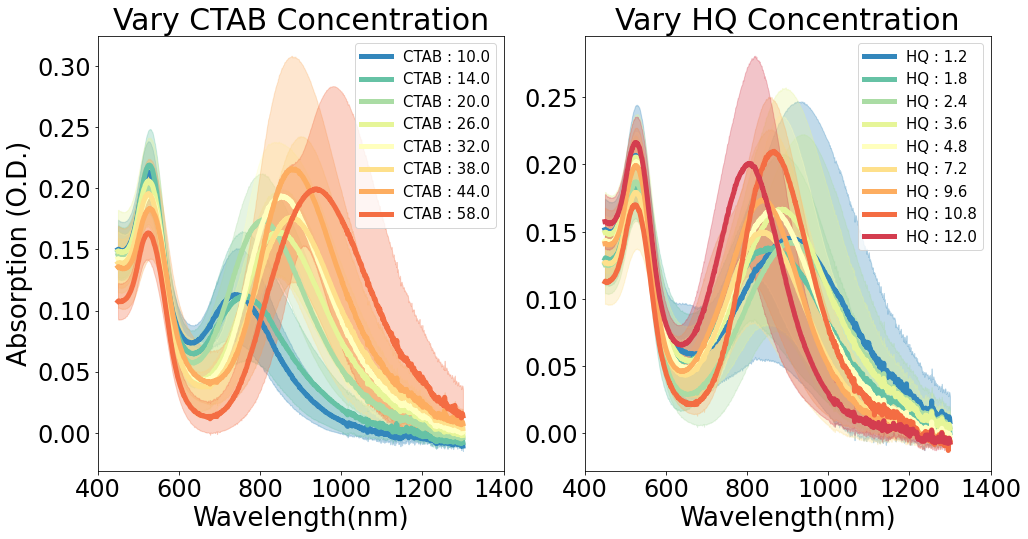

In [11]:
fig,ax = plt.subplots(1,2,figsize = (16,8))
labels = ['CTAB','HQ','NaBH4', 'Ag']

absorption_s = []
absorption_list = []
absorption = np.arange(450,1301,1)
for a in absorption:
    absorption_s.append('a' + str(int(a))) 
    absorption_list.append(str(int(a)))
concs = [100/500,60/500,0.3/500,5/500]
for i in range(2):
    sorts = fact_no_blanks[labels[i]].unique()
    sorts.sort()
    print(sorts)
    count = 0
    for sort in sorts:
        h12 = Fact.loc[Fact['Unnamed: 0'] =='H12']
        baseline = np.asarray(h12[absorption_s])[0]
        subsel = fact_no_blanks[fact_no_blanks[labels[i]] == sort]
        average = subsel[absorption_list].mean()- baseline
        # average = subsel[absorption_s].mean()
        average = average

        std = subsel[absorption_list].std()
        ax[i].plot(absorption, average, label = labels[i] + ' : ' + str(round(sort*concs[i],3)), color = color_list[count], linewidth = 5)
        ax[i].fill_between(absorption, average-std,average+std,alpha = 0.3, color = color_list[count])
        count += 1
    ax[i].set_title('Vary ' + labels[i] + ' Concentration', fontsize = 30)
    ax[i].legend(fontsize = 15)
    ax[i].set_xlabel('Wavelength(nm)', fontsize = 26)
    if i == 0:
        ax[i].set_ylabel('Absorption (O.D.)', fontsize = 26)
    ax[i].set_xlim(400,1400)
    for tick in ax[i].xaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    for tick in ax[i].yaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
plt.show()
    